# 🎓 Proyecto Final: Comparativa de Ecosistemas de IA (OpenAI vs. Google Gemini 2.0)

**Desarrollado por**: José Cisneros
**Curso**: Inteligencia Artificial - Generación de Prompts (Comisión 84185)  
**Profesor**: Ezequiel Tartaglia  
**Entrega**: Proyecto Final

## Resumen del Proyecto
Este proyecto realiza un análisis comparativo directo entre los ecosistemas de IA de **OpenAI (GPT-4 + DALL-E 3)** y **Google (Gemini 1.5 Pro + Gemini 2.0 Image Generation)**. Se evalúa el rendimiento de cada plataforma en la generación de contenido educativo multimodal (texto e imágenes). El análisis se enriquece con un **"Juez de IA"** que puntúa objetivamente la calidad del texto y un **dashboard interactivo** para explorar los resultados de **calidad, costo y rendimiento**.

In [1]:
# ===============================================================
# CELDA 1: IMPORTACIONES Y CONFIGURACIÓN
# ===============================================================
import openai
from google import genai
from google.genai import types
import time
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, Markdown, Image, HTML
import textwrap
import json
from PIL import Image as PILImage
from io import BytesIO
import base64
import os
import requests

# Crear carpetas para guardar las imágenes si no existen
if not os.path.exists('openai_images'):
    os.makedirs('openai_images')
if not os.path.exists('gemini_images'):
    os.makedirs('gemini_images')

pd.set_option('display.max_colwidth', 150)
plt.style.use('seaborn-v0_8-whitegrid')

print("✅ Librerías y configuración listas. Carpetas de imágenes preparadas.")

✅ Librerías y configuración listas. Carpetas de imágenes preparadas.


In [3]:
# ===============================================================
# CELDA 2: CONFIGURACIÓN DE API KEYS
# ===============================================================
openai_key_widget = widgets.Password(description="OpenAI Key:")
google_key_widget = widgets.Password(description="Google Key:")
display(widgets.HBox([openai_key_widget, google_key_widget]))

In [5]:
# ===============================================================
# LA CLASE IAComparator (CON GUARDADO LOCAL DE IMÁGENES)
# ===============================================================
# Esta celda puede tardar varios minutos debido a las pausas para la API.
class IAComparator:
    def __init__(self, openai_api_key, google_api_key):
        # --- Configuración de Clientes ---
        openai.api_key = openai_api_key
        self.gemini_client = genai.Client(api_key=google_api_key)
        
        # --- Crear carpetas de imágenes si no existen ---
        if not os.path.exists('openai_images'): os.makedirs('openai_images')
        if not os.path.exists('gemini_images'): os.makedirs('gemini_images')
            
        # --- Carga de Nombres de Modelos ---
        self.openai_model_text = "gpt-4"
        self.openai_model_image = "dall-e-3"
        self.gemini_model_multimodal = "gemini-2.0-flash-preview-image-generation"
        self.gemini_model_juez = "gemini-1.5-flash-latest"
        
        self.experimentos = []
        self.roles_educativos = {"primaria": "Eres una maestra de primaria creativa.", "secundaria": "Eres un profesor de secundaria moderno.", "universitario": "Eres un catedrático universitario riguroso."}
        
        # --- Precios para Estimación de Costos (Aproximadamente, no son los identicos) ---
        self.precios = {
            "gpt-4": {"input": 10.0/1e6, "output": 30.0/1e6},
            "gemini-flash": {"input": 0.35/1e6, "output": 1.05/1e6},
            "dall-e-3": 0.040,
            "gemini-image": 0.0025
        }
        print("✅ IA Comparator (con guardado local de imágenes) inicializado.")

    def _estimar_costo_texto(self, modelo_key, prompt, respuesta):
        tokens_prompt = len(prompt) / 4; tokens_respuesta = len(respuesta) / 4
        costo = ((tokens_prompt * self.precios[modelo_key]["input"]) + (tokens_respuesta * self.precios[modelo_key]["output"]))
        return costo

    def _construir_prompt_texto(self, tema, nivel):
        rol = self.roles_educativos[nivel]
        return f"**ROL:** {rol}.\n**TAREA:** Crea una explicación educativa completa sobre '{tema}' para un nivel de {nivel}.\n**ESTRUCTURA:** Sigue estos pasos: 1. Introducción, 2. Explicación, 3. Ejemplos, 4. Puntos Clave."
    
    def _construir_prompt_multimodal(self, tema, nivel):
        rol = self.roles_educativos[nivel]
        return (f"**ROL:** {rol}.\n"
                f"**TAREA:** Realiza dos acciones en una sola respuesta:\n"
                f"1.  **TEXTO:** Crea una explicación educativa completa sobre '{tema}'.\n"
                f"2.  **IMAGEN:** Basado en la explicación, genera una imagen educativa sobre '{tema}'.\n")

    def _generar_contenido_openai(self, prompt_texto, tema, nivel):
        response_texto = openai.ChatCompletion.create(model=self.openai_model_text, messages=[{"role": "user", "content": prompt_texto}])
        texto_generado = response_texto.choices[0].message.content
        costo_texto = self._estimar_costo_texto("gpt-4", prompt_texto, texto_generado)
        
        prompt_creator_prompt = f"Basado en este texto sobre '{tema}', crea un prompt para DALL-E 3 en inglés: \"{texto_generado[:400]}...\""
        response_prompt = openai.ChatCompletion.create(model=self.openai_model_text, messages=[{"role": "user", "content": prompt_creator_prompt}], max_tokens=100)
        prompt_imagen = response_prompt.choices[0].message.content
        costo_prompt_img = self._estimar_costo_texto("gpt-4", prompt_creator_prompt, prompt_imagen)
        
        try:
            img_response = openai.Image.create(model=self.openai_model_image, prompt=prompt_imagen, n=1, size="1024x1024")
            img_url = img_response['data'][0]['url']
            
            # --- Para Descargar y guardar la imagen de OpenAI ---
            filepath = f"openai_images/openai_img_{tema.replace(' ', '_')}_{int(time.time())}.png"
            response_img_data = requests.get(img_url)
            if response_img_data.status_code == 200:
                with open(filepath, 'wb') as f:
                    f.write(response_img_data.content)
                print(f"✅ Imagen de OpenAI guardada en: {filepath}")
                # Ahora devolvemos la ruta local, no la URL
                return texto_generado, filepath, costo_texto + costo_prompt_img + self.precios["dall-e-3"]
            else:
                return texto_generado, "Error al descargar imagen de URL", costo_texto + costo_prompt_img
        except Exception as e:
            return texto_generado, f"Error en DALL-E: {e}", costo_texto + costo_prompt_img

    def _generar_contenido_multimodal_gemini(self, prompt):
        try:
            response = self.gemini_client.models.generate_content(model=self.gemini_model_multimodal, 
                                                                  contents=prompt, 
                                                                  config=types.GenerateContentConfig(response_modalities=['TEXT', 'IMAGE']))
            texto_generado, ruta_imagen = "", "Error: No se generó imagen."
            for part in response.candidates[0].content.parts:
                if hasattr(part, 'text') and part.text: texto_generado += part.text
                elif hasattr(part, 'inline_data') and part.inline_data:
                    img_data = part.inline_data.data; image = PILImage.open(BytesIO(img_data)); 
                    filepath = f"gemini_images/gemini_img_{int(time.time())}.png"; image.save(filepath); ruta_imagen = filepath
            costo_total = self._estimar_costo_texto("gemini-flash", prompt, texto_generado) + self.precios["gemini-image"]
            return texto_generado, ruta_imagen, costo_total
        except Exception as e: return f"Error en Gemini Multimodal: {e}", "", 0.0

    def evaluar_con_ia_juez(self, texto_openai, texto_gemini, tema, nivel):
        prompt_juez = f"""Eres un evaluador experto. Analiza dos textos sobre '{tema}' para {nivel}. Evalúa de 0 a 10 Claridad, Creatividad y Precisión. Responde solo con un JSON.\n\nTEXTO A (OpenAI): "{texto_openai}"\n\nTEXTO B (Google Gemini): "{texto_gemini}"\n\nFormato JSON: {{"evaluacion_openai": {{"claridad": 0,"creatividad": 0,"precision": 0}}, "evaluacion_gemini": {{"claridad": 0,"creatividad": 0,"precision": 0}}}}"""
        try:
            response = self.gemini_client.models.generate_content(model=self.gemini_model_juez, contents=prompt_juez)
            return json.loads(response.text.strip().replace("```json", "").replace("```", "")), self._estimar_costo_texto("gemini-flash", prompt_juez, response.text)
        except Exception as e: print(f"Error en Juez: {e}"); return {"evaluacion_openai": {}, "evaluacion_gemini": {}}, 0.0

    def ejecutar_experimento(self, tema, nivel):
        prompt_texto_openai = self._construir_prompt_texto(tema, nivel)
        prompt_multimodal_gemini = self._construir_prompt_multimodal(tema, nivel)
        print(f"🧪 Ejecutando: {tema} ({nivel})...")
        
        start_g = time.time(); respuesta_g, img_g, costo_g = self._generar_contenido_multimodal_gemini(prompt_multimodal_gemini); end_g = time.time()
        print("   -> Pausando 20 segundos..."); time.sleep(20)
        
        start_oa = time.time(); respuesta_oa, img_oa, costo_oa = self._generar_contenido_openai(prompt_texto_openai, tema, nivel); end_oa = time.time()
        print("   -> Pausando 20 segundos antes del Juez..."); time.sleep(20)

        eval_juez, costo_juez = self.evaluar_con_ia_juez(respuesta_oa, respuesta_g, tema, nivel)
        puntuacion_oa, puntuacion_g = sum(eval_juez.get('evaluacion_openai', {}).values())/3, sum(eval_juez.get('evaluacion_gemini', {}).values())/3
        costo_total_oa, costo_total_g = costo_oa + (costo_juez / 2), costo_g + (costo_juez / 2)
        self.experimentos.append({"tema": tema, "nivel": nivel, "respuesta_openai": respuesta_oa, 
                                  "respuesta_gemini": respuesta_g, "tiempo_openai": end_oa - start_oa, 
                                  "tiempo_gemini": end_g - start_g, "img_openai": img_oa, "img_gemini": img_g, 
                                  "puntuacion_openai": puntuacion_oa, "puntuacion_gemini": puntuacion_g, 
                                  "costo_openai": costo_total_oa, "costo_gemini": costo_total_g, 
                                  "detalle_puntuacion_oa": eval_juez.get('evaluacion_openai', {}), 
                                  "detalle_puntuacion_g": eval_juez.get('evaluacion_gemini', {})})
        print(f"✅ Experimento {tema} ({nivel}) completado.")

    def obtener_dataframe_resultados(self):
        return pd.DataFrame(self.experimentos)
        

In [6]:
# ===============================================================
# FASE DE EJECUCIÓN DE EXPERIMENTOS
# ===============================================================
# Esta celda puede tardar varios minutos debido a las pausas para la API.
if not openai_key_widget.value or not google_key_widget.value:
    print("❌ Por favor, introduce ambas API keys en la Celda 2.")
else:
    comparator = IAComparator(openai_api_key=openai_key_widget.value, google_api_key=google_key_widget.value)
    temas_a_probar = ["Revolucion de Mayo - Argentina"]
    niveles_a_probar = ["primaria"]
    total_experimentos = len(temas_a_probar) * len(niveles_a_probar)
    experimento_actual = 0
    for tema in temas_a_probar:
        for nivel in niveles_a_probar:
            experimento_actual += 1
            print(f"\n--- INICIANDO EXPERIMENTO {experimento_actual}/{total_experimentos} ---")
            comparator.ejecutar_experimento(tema, nivel)
            if experimento_actual < total_experimentos:
                print("\n--- PAUSA LARGA ENTRE EXPERIMENTOS ---")
                time.sleep(60)
    df_resultados_final = comparator.obtener_dataframe_resultados()
    print("\n🎉 ¡Todos los experimentos han sido completados exitosamente!")
    display(df_resultados_final[['tema', 'nivel', 'puntuacion_openai', 'puntuacion_gemini', 'costo_openai', 'costo_gemini']].round(5))

✅ IA Comparator (con guardado local de imágenes) inicializado.

--- INICIANDO EXPERIMENTO 1/1 ---
🧪 Ejecutando: Revolucion de Mayo - Argentina (primaria)...
   -> Pausando 20 segundos...
✅ Imagen de OpenAI guardada en: openai_images/openai_img_Revolucion_de_Mayo_-_Argentina_1750436700.png
   -> Pausando 20 segundos antes del Juez...
✅ Experimento Revolucion de Mayo - Argentina (primaria) completado.

🎉 ¡Todos los experimentos han sido completados exitosamente!


tema     nivel  puntuacion_openai  \
0  Revolucion de Mayo - Argentina  primaria            7.33333   

   puntuacion_gemini  costo_openai  costo_gemini  
0            8.33333       0.06322       0.00323


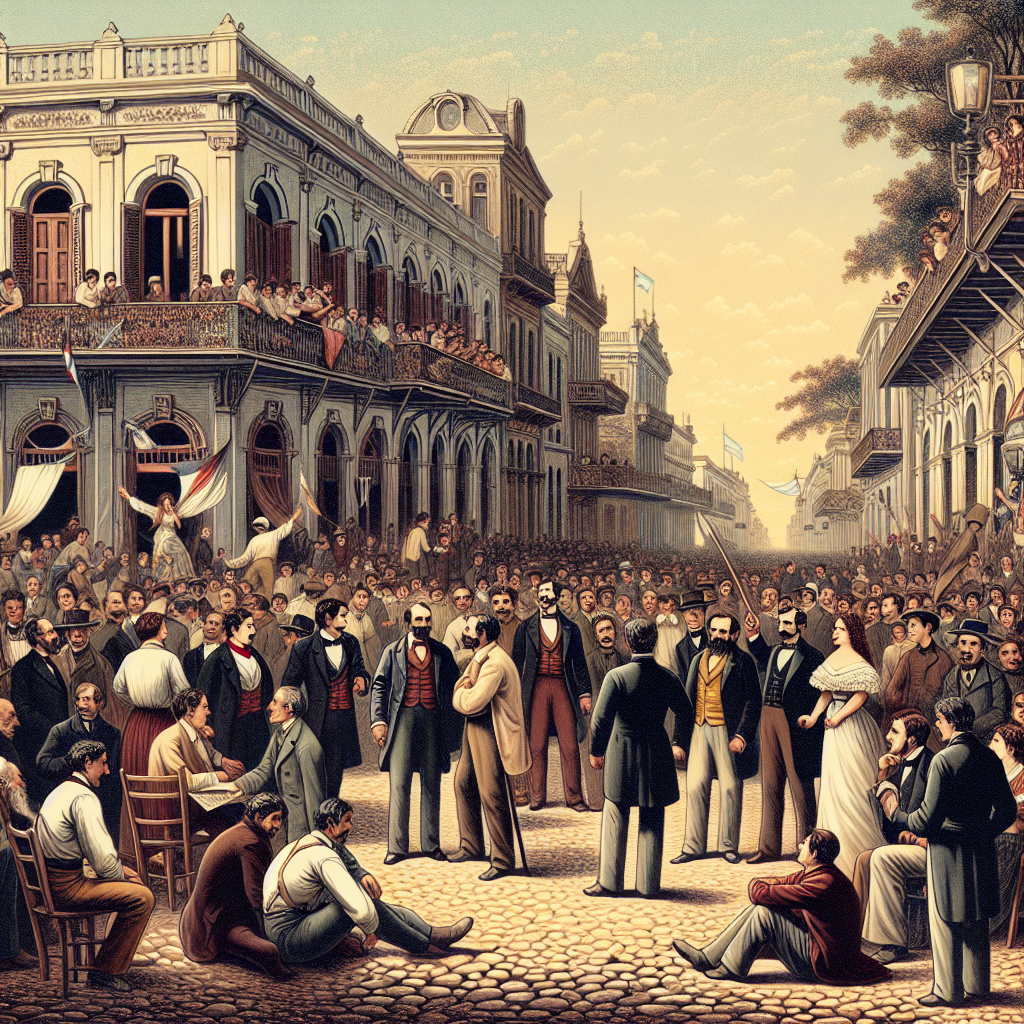
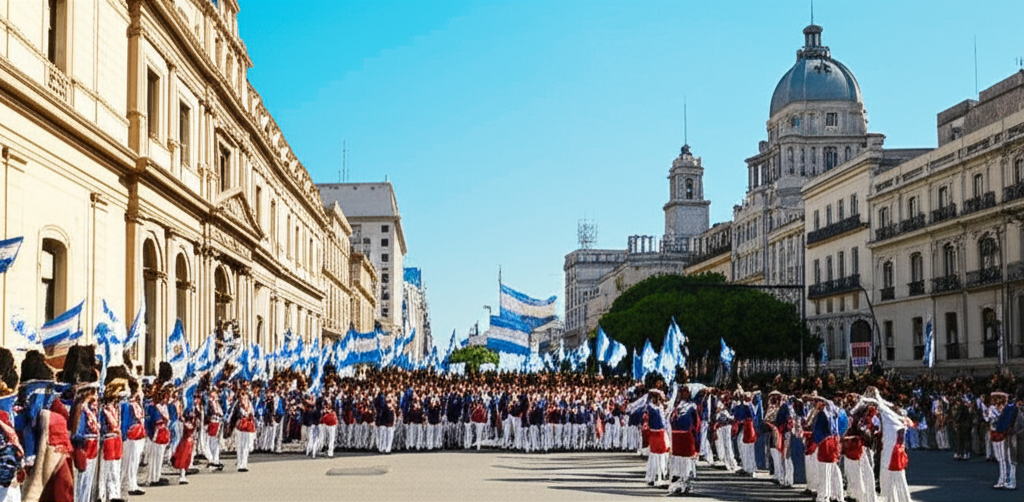

In [7]:
# ===============================================================
# FASE DE VISUALIZACIÓN DETALLADA (AMBAS IMÁGENES LOCALES)
# ===============================================================

# Función para codificar una imagen local a Base64
def encode_image_to_base64(filepath):
    try:
        with open(filepath, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')
    except (FileNotFoundError, TypeError):
        return None

if 'df_resultados_final' in locals() and not df_resultados_final.empty:
    for index, exp in df_resultados_final.iterrows():
        # Formatear textos y puntuaciones
        respuesta_openai_html = exp['respuesta_openai'].replace('\n', '<br>')
        respuesta_gemini_html = exp['respuesta_gemini'].replace('\n', '<br>')
        puntuacion_oa_str = f"<b>Claridad:</b> {exp['detalle_puntuacion_oa'].get('claridad', 'N/A')}/10 | <b>Creatividad:</b> {exp['detalle_puntuacion_oa'].get('creatividad', 'N/A')}/10 | <b>Precisión:</b> {exp['detalle_puntuacion_oa'].get('precision', 'N/A')}/10"
        puntuacion_g_str = f"<b>Claridad:</b> {exp['detalle_puntuacion_g'].get('claridad', 'N/A')}/10 | <b>Creatividad:</b> {exp['detalle_puntuacion_g'].get('creatividad', 'N/A')}/10 | <b>Precisión:</b> {exp['detalle_puntuacion_g'].get('precision', 'N/A')}/10"
        
        # --- imágenes a Base64 desde sus rutas locales ---
        base64_openai_img = encode_image_to_base64(exp['img_openai'])
        img_src_openai = f"data:image/png;base64,{base64_openai_img}" if base64_openai_img else ""
        
        base64_gemini_img = encode_image_to_base64(exp['img_gemini'])
        img_src_gemini = f"data:image/png;base64,{base64_gemini_img}" if base64_gemini_img else ""

        # HTML final para la visualización
        html = f"""
        <div style="border: 2px solid #4CAF50; padding: 15px; margin-bottom: 25px; border-radius: 10px; box-shadow: 2px 2px 5px #ccc;">
            <h2>Experimento: {exp['tema']} ({exp['nivel']})</h2><hr>
            <h3>1. Comparativa de Texto y Evaluación del Juez ⚖️</h3>
            <table width="100%">
                <thead><tr style="background-color: #f2f2f2; "><th width="50%" style="padding:10px;color: black;">🤖 OpenAI (GPT-4) - Puntuación: {exp['puntuacion_openai']:.2f}</th>
                <th width="50%" style="padding:10px; color: black;">✨ Google (Gemini) - Puntuación: {exp['puntuacion_gemini']:.2f}</th></tr><tr style="background-color: #FAFAFA;">
                <td style="padding: 8px; font-size: 12px;color: black;">{puntuacion_oa_str}</td><td style="padding: 8px; font-size: 12px;color: black;">{puntuacion_g_str}</td></tr></thead>
                <tbody><tr><td style="vertical-align:top;padding:10px;">{respuesta_openai_html}</td><td style="vertical-align:top;padding:10px;">{respuesta_gemini_html}</td></tr></tbody>
            </table><hr>
            <h3>2. Comparativa de Imágenes Generadas 🎨</h3>
            <table width="100%">
                <thead><tr style="background-color: #f2f2f2;"><th width="50%" style="padding:10px;color: black;">OpenAI (DALL-E 3)</th><th width="50%" style="padding:10px;color: black;">Google (Gemini 2.0 Image)</th></tr></thead>
                <tbody><tr><td style="text-align:center;padding:10px;"><img src="{img_src_openai}" width="400" style="border-radius: 5px;"></td><td style="text-align:center;padding:10px;">
                <img src="{img_src_gemini}" width="400" style="border-radius: 5px;"></td></tr></tbody>
            </table>
        </div>
        """
        display(HTML(html))
else:
    print("El DataFrame de resultados no está listo. Ejecuta la celda de experimentos primero.")
    

In [8]:
# ===============================================================
# DASHBOARD DE ANÁLISIS INTERACTIVO
# ===============================================================
if 'df_resultados_final' in locals() and not df_resultados_final.empty:
    nivel_dd = widgets.Dropdown(options=['Todos'] + list(df_resultados_final['nivel'].unique()), value='Todos', description='Filtrar Nivel:')
    metrica_dd = widgets.Dropdown(options=['Puntuación de Calidad', 'Tiempo Total (s)', 'Costo Estimado ($)'], 
                                  value='Puntuación de Calidad', description='Ver Métrica:')
    output_db = widgets.Output()
    def actualizar_dashboard(nivel, metrica):
        with output_db:
            output_db.clear_output(wait=True)
            df_f = df_resultados_final if nivel == 'Todos' else df_resultados_final[df_resultados_final['nivel'] == nivel]
            if metrica == 'Puntuación de Calidad': cols, titulo = ['puntuacion_openai', 'puntuacion_gemini'], f'Puntuación Promedio de Calidad (Nivel: {nivel})'
            elif metrica == 'Tiempo Total (s)': cols, titulo = ['tiempo_openai', 'tiempo_gemini'], f'Tiempo Promedio de Respuesta Total (s) (Nivel: {nivel})'
            else: cols, titulo = ['costo_openai', 'costo_gemini'], f'Costo Promedio Estimado por Experimento ($) (Nivel: {nivel})'
            promedios = df_f[cols].mean()
            fig, ax = plt.subplots(figsize=(8, 5)); bars = ax.bar(['OpenAI', 'Google'], promedios, color=['#4285F4', '#34A853'])
            ax.set_title(titulo, fontsize=16, pad=20); ax.set_ylabel(metrica); ax.bar_label(bars, fmt='%.5f' if metrica == 'Costo Estimado ($)' else '%.2f', padding=3); 
            ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False); plt.show()
    dashboard = widgets.VBox([widgets.HTML("<h2>📊 Dashboard Interactivo de Resultados</h2><p>Filtra los datos para explorar el rendimiento de cada ecosistema.</p>"), 
                              widgets.HBox([nivel_dd, metrica_dd]), output_db])
    display(dashboard)
    widgets.interactive_output(actualizar_dashboard, {'nivel': nivel_dd, 'metrica': metrica_dd})
else:
    print("Ejecuta los experimentos primero para ver el dashboard.")